In [1]:
# Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import pdb
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics
from joblib import dump, load
import keras
import itertools



### Data

In [3]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [4]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [6]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [6]:
def plotErrorGraph(history, epochs_size=30):

    # Making the plot larger
    plt.figure(figsize=(12, 8))

    loss = history.history['loss']                          # Loss on the training data
    val_loss = history.history['val_loss']                  # Loss on the validation data
    epochs = range(1, epochs_size+1)

    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
    plt.legend()

In [8]:

def data_operation(classifier=6):
    
        # Activities are the class labels
    # It is a 6 class classification
    ACTIVITIES = {
        0: 'WALKING',
        1: 'WALKING_UPSTAIRS',
        2: 'WALKING_DOWNSTAIRS',
        3: 'SITTING',
        4: 'STANDING',
        5: 'LAYING',
    }

    DATADIR = 'UCI_HAR_Dataset'

    
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    

        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append(
                _read_csv(filename).as_matrix()
            )
        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
#     def load_y(subset):
#         """
#         The objective that we are trying to predict is a integer, from 1 to 6,
#         that represents a human activity. We return a binary representation of 
#         every sample objective as a 6 bits vector using One Hot Encoding
#         (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
#         """
#         filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
#         y = _read_csv(filename)[0]

#         return pd.get_dummies(y).as_matrix()

    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        if classifier==2:
            y[y<=3] = 0
            y[y>3] = 1
            yi_=[]
        elif classifier==31:
            yi_ = y<=3
            y = y[yi_] 
        elif classifier==32:
            yi_ = y>3
            y = y[yi_] 
        else:
            yi_=[]
        return pd.get_dummies(y).as_matrix(),yi_
    
    
    if classifier==32 or classifier==31:
        Y_train,y_train_sub = load_y('train')
        Y_test,y_test_sub = load_y('test')
        X_train_s, X_test_s = load_signals('train'), load_signals('test')
        X_train = X_train_s[y_train_sub]
        X_test = X_test_s[y_test_sub]
    else:
        Y_train,tr = load_y('train')
        Y_test,ts = load_y('test')
        X_train, X_test = load_signals('train'), load_signals('test')

    
    return X_train, Y_train, X_test,  Y_test

reference : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5949027/

## Divide & Conquer-based 1D CNN HAR

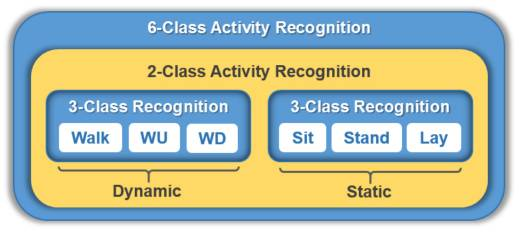

Here we will solve problem using different approach, firstly we will class into two class **Static** and **Dynamic**.

WALKING, WALKING UPSTRAIRS, WALKING DOWNSTRAIRS are considered as Dynamic

SITTING, STANDING, LAYING are considered as Static

In [44]:
X_train, Y_train, X_test,  Y_test = data_operation(2)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(7352, 128, 9) (7352, 2)
(2947, 128, 9) (2947, 2)


In [10]:


# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization


### Two class Classifiction

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 4s 519us/step - loss: 0.0913 - acc: 0.9671 - val_loss: 0.1033 - val_acc: 0.9467
Epoch 2/30
7352/7352 [==============================] - 2s 311us/step - loss: 0.0256 - acc: 0.9914 - val_loss: 0.0951 - val_acc: 0.9569
Epoch 3/30
7352/7352 [==============================] - 2s 301us/step - loss: 0.0204 - acc: 0.9933 - val_loss: 0.0185 - val_acc: 0.9942
Epoch 4/30
7352/7352 [==============================] - 2s 302us/step - loss: 0.0129 - acc: 0.9955 - val_loss: 0.0075 - val_acc: 0.9990
Epoch 5/30
7352/7352 [==============================] - 2s 302us/step - loss: 0.0190 - acc: 0.9951 - val_loss: 0.0172 - val_acc: 0.9932
Epoch 6/30
7352/7352 [==============================] - 2s 302us/step - loss: 0.0110 - acc: 0.9965 - val_loss: 0.0041 - val_acc: 0.9986
Epoch 7/30
7352/7352 [==============================] - 2s 305us/step - loss: 0.0101 - acc: 0.9976 - val_loss: 0.0035 - val_acc: 0.9993


[0.0014044928401187003, 0.999660671869698]

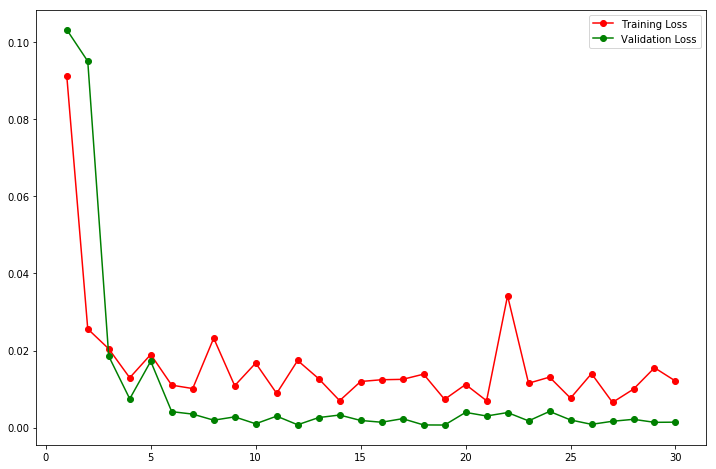

In [45]:

n_classes = 2

twoClassmodel = Sequential()
twoClassmodel.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(128, 9)))
twoClassmodel.add(Dropout(0.5))
twoClassmodel.add(MaxPooling1D(pool_size=2))
twoClassmodel.add(BatchNormalization())
twoClassmodel.add(Flatten())
twoClassmodel.add(Dropout(0.7))
twoClassmodel.add(Dense(n_classes, activation='softmax'))
twoClassmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training the model
history = twoClassmodel.fit(X_train,
          Y_train,
          batch_size=16,
          validation_data=(X_test, Y_test),
          epochs=30)
plotErrorGraph(history,30)
dump(twoClassmodel,'/home/pranay/Case Study/FitBit/HumanActivityRecognition/HAR/twoClassmodel')
score = twoClassmodel.evaluate(X_test,Y_test)
score


While two class, classification we can observe, we can separate static and dynamic class with very good accuracy.

## Static Classification

In [25]:
X_train, Y_train, X_test,  Y_test = data_operation(32)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(4067, 128, 9) (4067, 3)
(1560, 128, 9) (1560, 3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 123, 32)           1760      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 121, 16)           1552      
_________________________________________________________________
dropout_24 (Dropout)         (None, 121, 16)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 60, 16)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 60, 16)            64        
_________________________________________________________________
flatten_12 (Flatten)         (None, 960)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 960)               0         
__________

[0.13269949434964906, 0.9632299927901946]

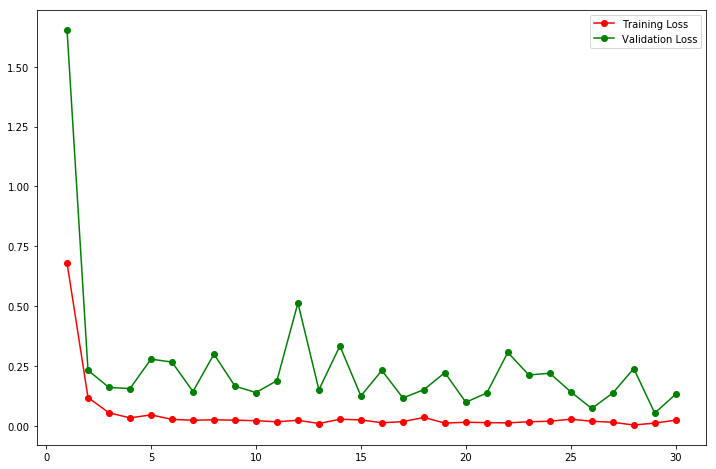

In [23]:
staticModel = Sequential()
staticModel.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(128, 9)))
staticModel.add(Conv1D(filters=16, kernel_size=3, activation='relu'))

staticModel.add(Dropout(0.2))
staticModel.add(MaxPooling1D(pool_size=2))
staticModel.add(BatchNormalization())
staticModel.add(Flatten())
staticModel.add(Dropout(0.3))
staticModel.add(Dense(64, activation='relu'))
staticModel.add(Dropout(0.4))
staticModel.add(Dense(3, activation='softmax'))
staticModel.summary()
staticModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = staticModel.fit(X_train,
          Y_train,
          batch_size=16,
          validation_data=(X_test, Y_test),
          epochs=30)
plotErrorGraph(history,30)
dump(staticModel,'/home/pranay/Case Study/FitBit/HumanActivityRecognition/HAR/staticModel')

score = staticModel.evaluate(X_test, Y_test)
score

## Dynamic Classification

In [11]:
X_train, Y_train, X_test,  Y_test = data_operation(31)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(3285, 128, 9) (3285, 3)
(1387, 128, 9) (1387, 3)


Train on 3285 samples, validate on 1387 samples
Epoch 1/30
3285/3285 [==============================] - 2s 573us/step - loss: 1.0762 - acc: 0.5476 - val_loss: 0.7879 - val_acc: 0.6828
Epoch 2/30
3285/3285 [==============================] - 1s 278us/step - loss: 0.3216 - acc: 0.8804 - val_loss: 0.4181 - val_acc: 0.8385
Epoch 3/30
3285/3285 [==============================] - 1s 277us/step - loss: 0.1381 - acc: 0.9531 - val_loss: 0.3021 - val_acc: 0.8803
Epoch 4/30
3285/3285 [==============================] - 1s 278us/step - loss: 0.1056 - acc: 0.9647 - val_loss: 0.2519 - val_acc: 0.9106
Epoch 5/30
3285/3285 [==============================] - 1s 276us/step - loss: 0.0657 - acc: 0.9787 - val_loss: 0.3988 - val_acc: 0.8248
Epoch 6/30
3285/3285 [==============================] - 1s 276us/step - loss: 0.0454 - acc: 0.9872 - val_loss: 0.1533 - val_acc: 0.9517
Epoch 7/30
3285/3285 [==============================] - 1s 280us/step - loss: 0.0556 - acc: 0.9830 - val_loss: 0.1314 - val_acc: 0.9582


[0.03154490509509411, 0.989185291997116]

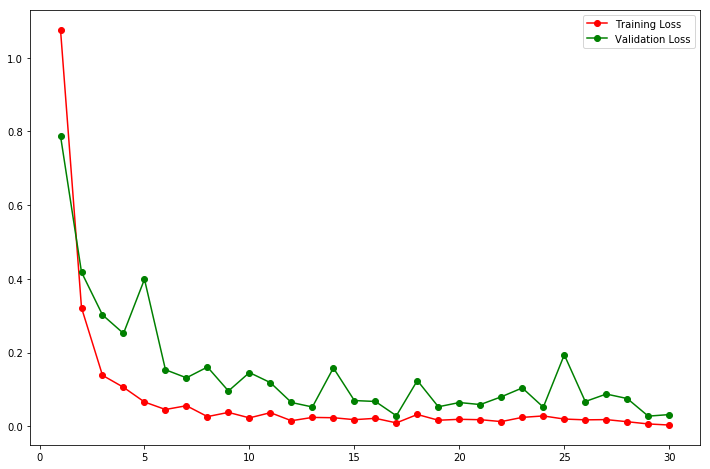

In [19]:

dynamicModel = Sequential()
dynamicModel.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(128, 9)))
dynamicModel.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
dynamicModel.add(Dropout(0.5))
dynamicModel.add(MaxPooling1D(pool_size=2))
dynamicModel.add(BatchNormalization())
dynamicModel.add(Flatten())
dynamicModel.add(Dropout(0.5))
dynamicModel.add(Dense(3, activation='softmax'))
dynamicModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training the model
history = dynamicModel.fit(X_train,
          Y_train,
          batch_size=16,
          validation_data=(X_test, Y_test),
          epochs=30)
plotErrorGraph(history,30)
dump(dynamicModel,'/home/pranay/Case Study/FitBit/HumanActivityRecognition/HAR/dynamicModel1')

score = dynamicModel.evaluate(X_test,Y_test)
score


## Model Evaluation

### Two class

In [46]:
X_train, Y_train, X_test,  Y_test = data_operation(2)



ACTIVITIES = {
    0: 'DYNAMIC',
    1: 'STATIC',

}

twoclass_pred = twoClassmodel.predict(X_test)

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(twoclass_pred, axis=1)])

cm = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

# Confusion Matrix
print(cm)

/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Pred     DYNAMIC  STATIC
True                    
DYNAMIC     1387       0
STATIC         1    1559


## Static Classification

In [32]:
X_train, Y_train, X_test,  Y_test = data_operation(32)



ACTIVITIES = {
        0: 'SITTING',
        1: 'STANDING',
        2: 'LAYING',

}

static_class_pred = staticModel.predict(X_test)

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(static_class_pred, axis=1)])

cm = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

# Confusion Matrix
print(cm)

/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Pred      LAYING  SITTING  STANDING
True                               
LAYING       310        0       227
SITTING      160      185       146
STANDING       0      342       190


## Dynamic Classification

In [33]:
X_train, Y_train, X_test,  Y_test = data_operation(31)



ACTIVITIES = {
      0: 'WALKING',
      1: 'WALKING_UPSTAIRS',
      2: 'WALKING_DOWNSTAIRS',

}

static_class_pred = dynamicModel.predict(X_test)

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(static_class_pred, axis=1)])

cm = pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

# Confusion Matrix
print(cm)

/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/pranay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Pred                WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                                             
WALKING                 489                   6                 1
WALKING_DOWNSTAIRS        2                 417                 1
WALKING_UPSTAIRS          0                   5               466


## Final Results

Two class classification = 99.96% Accuracy

Static classification = 96.32% Accuracy

Two class classification = 98.91% Accuracy

# Conclusion

In [50]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "Train Loss", "Train Accuracy", "Test Loss","Test Accuracy"]
x.add_row(['Two class','0.0121','0.9977','0.0014','0.9997'])
x.add_row(['Static ','0.0242','0.9930','0.1327','0.9632'])
x.add_row(['Dynamic','0.0032','0.9991','0.0315','0.9892'])

print(x)

+-----------+------------+----------------+-----------+---------------+
|   Model   | Train Loss | Train Accuracy | Test Loss | Test Accuracy |
+-----------+------------+----------------+-----------+---------------+
| Two class |   0.0121   |     0.9977     |   0.0014  |     0.9997    |
|  Static   |   0.0242   |     0.9930     |   0.1327  |     0.9632    |
|  Dynamic  |   0.0032   |     0.9991     |   0.0315  |     0.9892    |
+-----------+------------+----------------+-----------+---------------+


- In above problem we took **Divide and Conquer** approach.
- We can observe that Training loss and Test loss have not much difference in all models so model is surely note overfitting.
- There is some confusion in SITTING, LAYING classes.
- In dynamic classification its really good classification.
- Extension for this case study is that we can sub-divide Static class and check what is happening.